# Build Target Model

Here we work to expand our on target rules to include information about the target site.
We consider three feature classes when building this model:

1. Position within a gene
  1. Guide orientation relative to the direction of transcription
  2. Distance to the end of the CDS
  3. Distance to the start of the CDS
  4. Percent of CDS
2. Protein Domain information:
  1. Whether a guide targets within an annotated protein domain
3. Sequence conservation:
  1. Conservation of 3 nucleotide preceding the cut site
  2. "" succeeding the cut site
  3. Conservation of
4. Amino acid information:
  1. Position independent one-mers
  2. "" two-mers
  3. Position dependent one-mers


In [1]:
import pandas as pd
from datasets import dataset_list
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.base import clone
import joblib
import sglearn
import seaborn as sns
from tqdm import tqdm
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import plotnine as gg
import shap
from core import (get_predictive_performance,
                  plot_pearson_heatmap,
                  plot_relative_performance)
from scipy import stats
import target_featurization as ft

In [2]:
def train_test_model(X_train, y_train, model_name, fold, model, test_df, X_test):
    """Get predictions from train and test model

    :param train_df: DataFrame
    :param model_name: str, name of model
    :param fold: int
    :param model: model with a .fit function
    :param test_df: DataFrame
    :param X_test: DataFrame from sglearn.featurize_guides
    :return: DataFrame, same shape as test_df with columns prediction, model, fold
    """
    # TODO - modify featurization
    model.fit(X_train,  y_train)
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_train)
    shap_df = pd.DataFrame(shap_values, columns=X_train.columns)
    shap_importance = shap_df.abs().mean(0)
    dataset_test_predictions = test_df.copy()
    dataset_test_predictions['prediction'] = model.predict(X_test)
    dataset_test_predictions['model_name'] = model_name
    dataset_test_predictions['fold'] = fold
    return dataset_test_predictions, shap_importance


def get_fold_predictions(fold, fold_df, model_name, features,
                         aa_seq_df, protein_domain_df, conservation_df,
                         base_model=LGBMRegressor(random_state=7, n_jobs=8)):
    """Get predictions for a given fold, allowing for each dataset to be trained separately,
    or multiple datasets trained together

    :param fold: int
    :param fold_df: DataFrame
    :param base_model: model with a .fit function
    :param features: list
    :param model_name: str optional, only relevant if top_datasets is specified
    :return: list of DataFrame, list of test predictions
    """
    train_df = fold_df.query('train == True').reset_index(drop=True)
    train_feature_df, train_feature_cols = ft.build_target_feature_df(train_df,
                                                                      features=features,
                                                                      aa_seq_df=aa_seq_df,
                                                                      protein_domain_df=protein_domain_df,
                                                                      conservation_df=conservation_df)
    X_train = train_feature_df[train_feature_cols]
    y_train = train_df['Residual Activity']
    test_df = fold_df.query('train == False').reset_index(drop=True)
    test_feature_df, test_feature_cols = ft.build_target_feature_df(test_df,
                                                                    features=features,
                                                                    aa_seq_df=aa_seq_df,
                                                                    protein_domain_df=protein_domain_df,
                                                                    conservation_df=conservation_df)
    X_test = test_feature_df[test_feature_cols]
    model = clone(base_model)
    dataset_test_predictions, shap_imp_series = train_test_model(X_train, y_train, model_name, fold,
                                                                 model, test_df, X_test)
    # return a list of length of one to combine with other training runs
    return dataset_test_predictions, shap_imp_series


## Reading Data

In [3]:
train_data_names = pd.read_csv('../data/processed/train_data_names.csv').name.to_list()
protein_domains = pd.read_csv('../data/interim/protein_domains.csv')
aa_seqs = pd.read_csv('../data/interim/aa_seqs.csv')
seq_model = joblib.load('../models/RuleSet3.pkl')

In [4]:
### Rename Database Columns

In [5]:
aa_seqs = aa_seqs.rename({'query': 'Transcript Base'}, axis=1)
protein_domains = protein_domains.rename({'Parent': 'Transcript Base'}, axis=1)

## Loading Datasets

In [6]:
train_data_list = list()
for ds in dataset_list:
    if (ds.name in train_data_names) and ds.endogenous:
        train_data_list.append(ds)

for ds in train_data_list:
    ds.load_data()
    ds.set_sgrnas()


## Merging Training Data

In [7]:
sg_df_list = []
for ds in tqdm(train_data_list):
    sg_df = ds.get_sg_df(include_group=True, include_activity=True)
    sg_df['dataset'] = ds.name
    design_df = ds.get_designs()
    sg_df = sg_df.merge(design_df, how='inner',
                        on=['sgRNA Sequence', 'sgRNA Context Sequence', 'PAM Sequence'])
    sg_df_list.append(sg_df)
sg_df_groups = (pd.concat(sg_df_list)
                .groupby(['sgRNA Context Sequence'])
                .agg(n_conditions = ('sgRNA Context Sequence', 'count'),
                     target = ('sgRNA Target', lambda x: ', '.join(set([s.upper() for s in x if not pd.isna(s)]))))
                .reset_index())
multi_target = sg_df_groups['target'].str.contains(',').sum()
print('Context sequences with multiple targets: ' + str(multi_target))

100%|██████████| 4/4 [00:12<00:00,  3.09s/it]


Context sequences with multiple targets: 0


In [8]:
# handle singleton case
sg_df_groups['target'] = sg_df_groups.apply(lambda row:
                                            row['target'] if (row['target'] != '') else row['sgRNA Context Sequence'],
                                            axis=1)
# Note that 'target' is not in the sg_df_list, and is coming from the sg_df_groups df
sg_df_class_groups = (pd.concat(sg_df_list)
                      .merge(sg_df_groups, how='inner', on='sgRNA Context Sequence')
                      .sort_values(['dataset', 'target'])
                      .reset_index(drop=True))
sg_df_class_groups = ft.add_target_columns(sg_df_class_groups)


## Protein Domain Features

In [9]:
domain_model_matrix = ft.get_protein_domain_features(sg_df_class_groups, protein_domains)

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.


[]

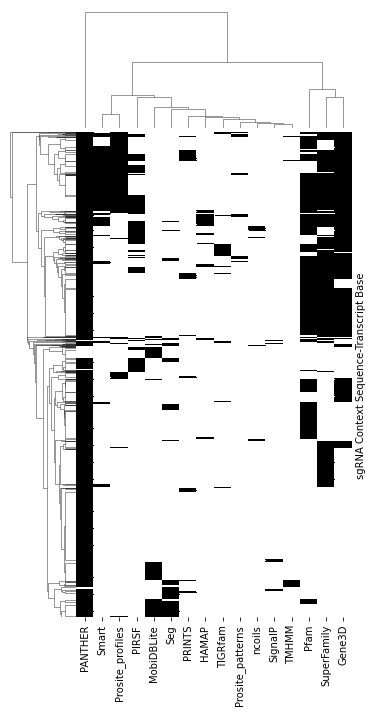

In [11]:
g = sns.clustermap(domain_model_matrix.set_index(['sgRNA Context Sequence', 'Transcript Base']),
                   cmap='binary', cbar_pos=None, metric='hamming')
g.ax_heatmap.get_yaxis().set_ticks([])

## Conservation of Protein Domains

We'll merge conservation scores with the protein domain matrix to understand how protein domains are conserved

In [12]:
transcript_bases = list(sg_df_class_groups['Transcript Base']
                        .unique())
conservation_df = (pd.read_parquet('../data/interim/conservation.parquet',
                                   filters=[[('Transcript Base', 'in', transcript_bases)]])
                   .reset_index(drop=True))
conservation_df['ranked_conservation'] = (conservation_df.groupby('Transcript Base')
                                          ['conservation']
                                          .rank(pct=True))


In [13]:
conservation_aa_i = conservation_df.copy()
conservation_aa_i['aa_i'] = (conservation_aa_i['target position'] - 1) // 3 + 1
conservation_aa_i['loc_id'] = conservation_aa_i['Transcript Base'] + conservation_aa_i['aa_i'].astype(str)
# Filter sifts
conservation_domains = (conservation_aa_i.merge(protein_domains[protein_domains['type'] != 'sifts'],
                                                how='inner',
                                                on='Transcript Base'))
conservation_domains = (conservation_domains[conservation_domains['aa_i']
                        .between(conservation_domains['start'], conservation_domains['end'])])
conservation_non_domains = conservation_aa_i[~conservation_aa_i['loc_id'].isin(conservation_domains['loc_id'])]
conservation_cat = (pd.concat([conservation_domains, conservation_non_domains])
                    .reset_index(drop=True))
conservation_cat['type'] = conservation_cat['type'].fillna('None')
conservation_cat_summary = (conservation_cat.groupby(['type', 'genome'])
                            .agg(median_conservation = ('conservation', 'median'),
                                 n_obs = ('conservation', 'count'))
                            .reset_index()
                            .sort_values('median_conservation'))
conservation_cat_summary['name'] = (conservation_cat_summary['type'] +
                                    '(n=' +
                                    conservation_cat_summary['n_obs'].astype(str) +
                                    ')')
hg_conservation_cat_summary = conservation_cat_summary[conservation_cat_summary['genome'].str.contains('hg')]
mm_conservation_cat_summary = conservation_cat_summary[conservation_cat_summary['genome'].str.contains('mm')]
hg_conservation_cat = conservation_cat.merge(hg_conservation_cat_summary, how='inner')
hg_conservation_cat['name'] = pd.Categorical(hg_conservation_cat['name'],
                                             categories=hg_conservation_cat_summary['name'])
mm_conservation_cat = conservation_cat.merge(mm_conservation_cat_summary, how='inner')
mm_conservation_cat['name'] = pd.Categorical(mm_conservation_cat['name'],
                                             categories=mm_conservation_cat_summary['name'])

Text(0.5, 1.0, 'Human Training Data\nDomain Conservation')

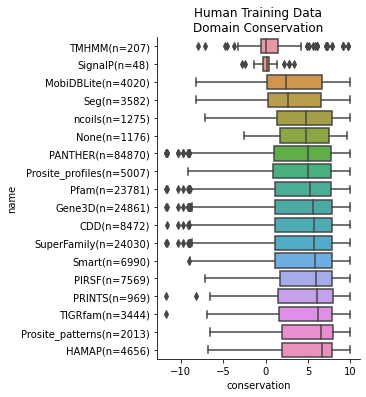

In [14]:
sns.catplot(data=hg_conservation_cat, y='name', x='conservation', kind='box')
plt.title('Human Training Data\nDomain Conservation')

Text(0.5, 1.0, 'Mouse Training Data\nDomain Conservation')

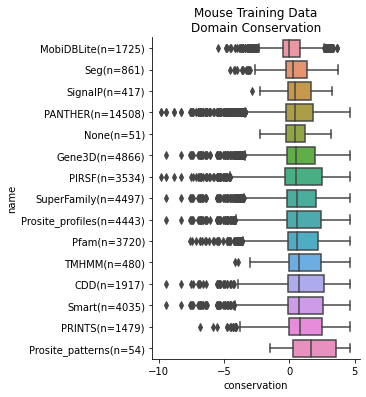

In [15]:
sns.catplot(data=mm_conservation_cat, y='name', x='conservation', kind='box')
plt.title('Mouse Training Data\nDomain Conservation')

## Calculating Residuals

In [16]:
sg_df_residuals = sg_df_class_groups.copy()
sg_df_residuals['sgRNA Activity'] = (sg_df_residuals.groupby('dataset')
                                     ['sgRNA Activity']
                                     .rank(pct=True))
seq_X = sglearn.featurize_guides(sg_df_residuals['sgRNA Context Sequence'])
sg_df_residuals['Rule Set 3'] = seq_model.predict(seq_X)
(sg_df_residuals.groupby('dataset')
 .apply(lambda df: stats.pearsonr(df['Rule Set 3'], df['sgRNA Activity'])))

dataset
Doench2014_human     (0.7747588150394162, 6.327280047472541e-200)
Doench2014_mouse    (0.7221909327038771, 4.8841724249361805e-189)
Doench2016                        (0.6639725734142461, 3.06e-322)
Wang2014              (0.740204397054155, 4.967999241925921e-178)
dtype: object

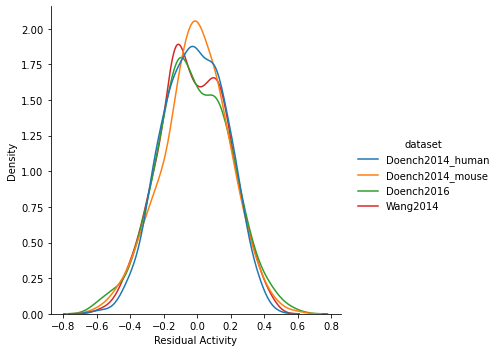

In [17]:
sg_df_residuals['Residual Activity'] = sg_df_residuals['sgRNA Activity'] - sg_df_residuals['Rule Set 3']
sns.displot(data=sg_df_residuals, x='Residual Activity', hue='dataset',
            kind='kde', common_norm=False)

## Cross Validation iterator

We'll use [StratifiedGroupKFold](https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.StratifiedGroupKFold.html#sklearn.model_selection.StratifiedGroupKFold)

We define each dataset as a "class", such that the datasets are approximately equally distributed across
folds, constrained by the notion that each "group" or gene cannot appear in both the train and test set in a given fold.

First, we assign sgRNAs to genes, capitalizing gene-names from the mouse libraries, so they overlap with the human annotations.
We can see that every context sequence uniquely targets a gene in this dataset

We assign context sequences without a group to their own group. Every dataset appears as both a training and testing
dataset in every fold, except Doench2014_human Doench2014_mouse, which have fewer than 5 genes

We see again that the Doench Human and Mouse data do not appear in every train/test fold due to the relatively
small number of genes.

In [18]:
sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=1)
tidy_cv_list = []
for i, (train_index, test_index) in enumerate(sgkf.split(sg_df_residuals, sg_df_residuals.dataset,
                                                         sg_df_residuals.target)):
    train_df = sg_df_residuals.iloc[train_index,:].copy()
    train_df['cv'] = i
    train_df['train'] = True
    tidy_cv_list.append(train_df)
    test_df = sg_df_residuals.iloc[test_index,:].copy()
    test_df['cv'] = i
    test_df['train'] = False
    tidy_cv_list.append(test_df)
tidy_cv_df = pd.concat(tidy_cv_list)
cv_train_data_counts = (tidy_cv_df[['cv', 'train', 'dataset']].value_counts()
                        .reset_index(name='n'))
(cv_train_data_counts[['cv', 'dataset']]
 .value_counts()
 .reset_index(name='n')
 .sort_values(['n', 'cv', 'dataset']))

,cv,dataset,n
19,0,Doench2014_human,1
18,1,Doench2014_human,1
17,2,Doench2014_human,1
16,2,Doench2014_mouse,1
1,0,Doench2014_mouse,2
15,0,Doench2016,2
14,0,Wang2014,2
13,1,Doench2014_mouse,2
12,1,Doench2016,2
11,1,Wang2014,2


- Training sizes vary from 5,258 - 4,253 sgRNAs
- Testing sizes vary from 1,469 - 464 sgRNAs

In [19]:
(tidy_cv_df[['cv','train']].value_counts()
 .reset_index(name='n')
 .sort_values(['cv', 'train']))

,cv,train,n
9,0,False,464
0,0,True,5258
6,1,False,1441
3,1,True,4281
8,2,False,1093
1,2,True,4629
5,3,False,1469
4,3,True,4253
7,4,False,1255
2,4,True,4467


Indeed each gene target (gene) only appears in one set in each fold

In [20]:
(tidy_cv_df[['cv','train', 'target']].value_counts()
 .reset_index(name='n')
 .query('n > 10')
 [['cv', 'target']].value_counts()
 .reset_index(name='train_test_sum')
 .groupby('cv')
 .agg({'train_test_sum': ['max']}))

,train_test_sum
,max
cv,
0,1
1,1
2,1
3,1
4,1


## Testing Feature Sets

### Single Feature Sets

In [21]:
single_prediction_list = []
features = ['position', 'aa', 'domain', 'conservation']
for feature in features:
    print(feature)
    for fold, df in tidy_cv_df.groupby('cv'):
        print('Fold: ' + str(fold))
        predictions, _ = get_fold_predictions(fold, df, model_name=feature,
                                              features=[feature],
                                              aa_seq_df=aa_seqs,
                                              protein_domain_df=protein_domains,
                                              conservation_df=conservation_df)
        single_prediction_list.append(predictions)
    print('\n')

single_predictive_performance = get_predictive_performance(single_prediction_list)


position
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4


aa
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4


domain
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4


conservation
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4




All features seem to be learning salient features with the notable exception of positional features in fold 3.
This will be interesting to investigate as domain features are important here.

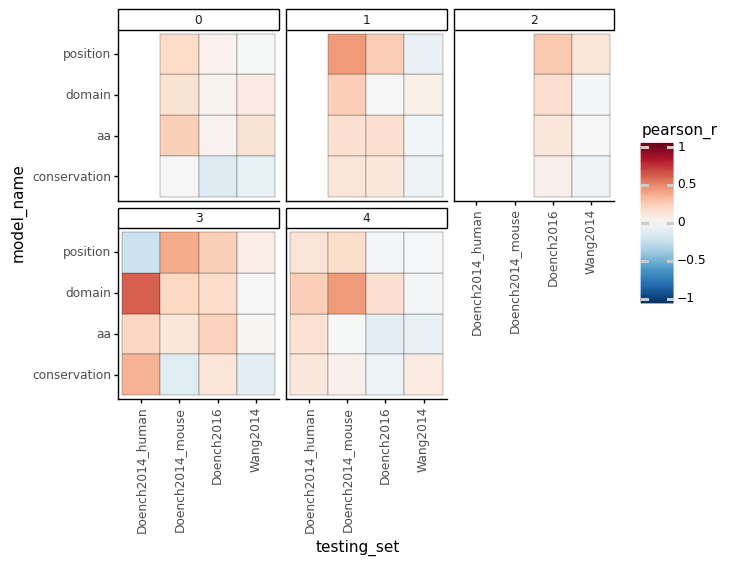

<ggplot: (8765900692026)>

In [22]:
plot_pearson_heatmap(single_predictive_performance)

In [23]:
(single_predictive_performance.groupby('model_name')
 .agg({'pearson_r': ['median', 'mean', 'std']}))

pearson_r                    
                median      mean       std
model_name                                
conservation  0.027899  0.026228  0.124848
aa            0.120358  0.085463  0.110101
domain        0.152328  0.156964  0.168310
position      0.128461  0.123974  0.168725

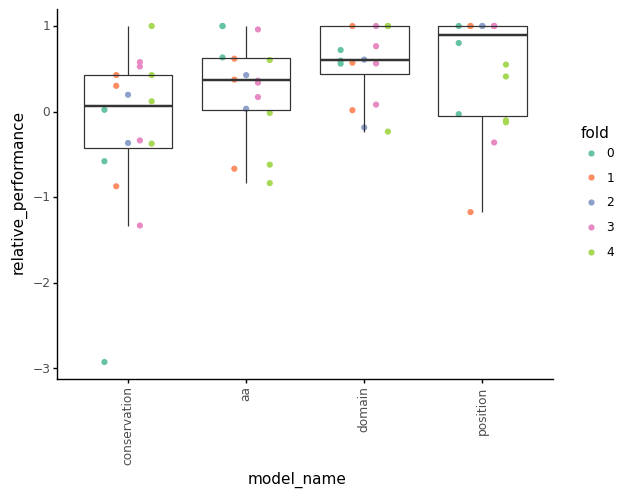

<ggplot: (8765890720413)>

In [24]:
plot_relative_performance(single_predictive_performance)

### Complete Feature Set

In [25]:
complete_feature_list = []
features = ['position', 'aa', 'domain', 'conservation']
for fold, df in tidy_cv_df.groupby('cv'):
    print('Fold: ' + str(fold))
    predictions, _ = get_fold_predictions(fold, df, model_name='All',
                                          features=features,
                                          aa_seq_df=aa_seqs,
                                          protein_domain_df=protein_domains,
                                          conservation_df=conservation_df)
    complete_feature_list.append(predictions)

complete_predictive_performance = get_predictive_performance(complete_feature_list + single_prediction_list)

Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4


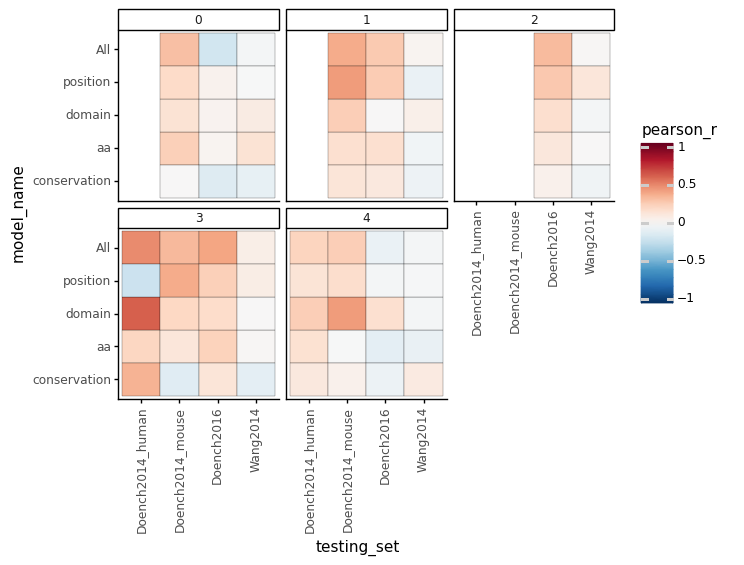

<ggplot: (8765876256967)>

In [26]:
plot_pearson_heatmap(complete_predictive_performance)

In [27]:
(complete_predictive_performance.groupby('model_name')
 .agg({'pearson_r': ['median', 'mean', 'std']}))

pearson_r                    
                median      mean       std
model_name                                
conservation  0.027899  0.026228  0.124848
aa            0.120358  0.085463  0.110101
domain        0.152328  0.156964  0.168310
position      0.128461  0.123974  0.168725
All           0.235499  0.170220  0.196326

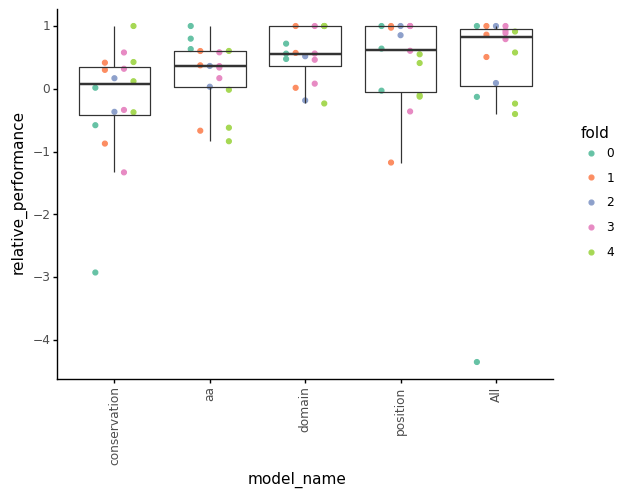

<ggplot: (8765927469174)>

In [28]:
plot_relative_performance(complete_predictive_performance)


### Leave One Set Out


In [29]:
leave_one_prediction_list = []
features = ['position', 'aa', 'domain', 'conservation']
for feature in features:
    print(feature)
    curr_features = features.copy()
    curr_features.remove(feature)
    for fold, df in tidy_cv_df.groupby('cv'):
        print('Fold: ' + str(fold))
        predictions, _ = get_fold_predictions(fold, df, model_name='No ' + feature,
                                              features=curr_features,
                                              aa_seq_df=aa_seqs,
                                              protein_domain_df=protein_domains,
                                              conservation_df=conservation_df)
        leave_one_prediction_list.append(predictions)
    print('\n')

leave_one_predictive_performance = get_predictive_performance(leave_one_prediction_list + complete_feature_list +
                                                              single_prediction_list)

position
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4


aa
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4


domain
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4


conservation
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4




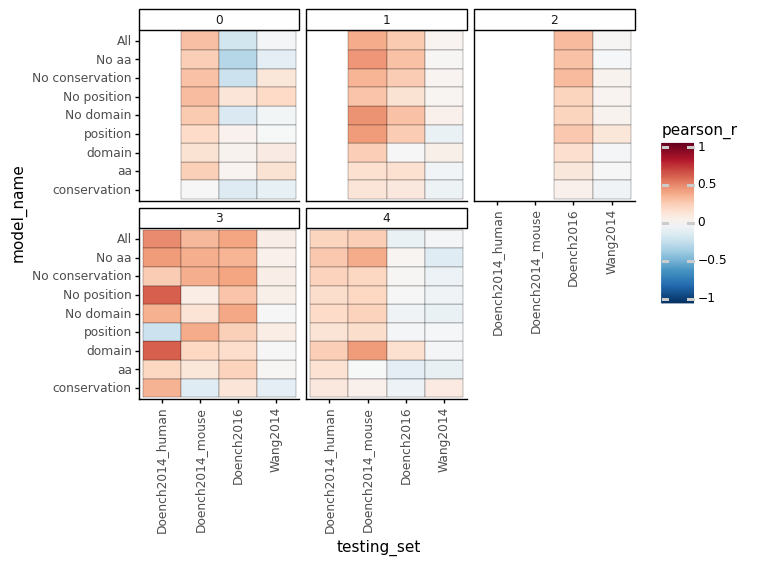

<ggplot: (8765910692940)>

In [30]:
plot_pearson_heatmap(leave_one_predictive_performance)

In [31]:
(leave_one_predictive_performance.groupby('model_name')
 .agg({'pearson_r': ['median', 'mean', 'std']}))

pearson_r                    
                   median      mean       std
model_name                                   
conservation     0.027899  0.026228  0.124848
aa               0.120358  0.085463  0.110101
domain           0.152328  0.156964  0.168310
position         0.128461  0.123974  0.168725
No domain        0.165713  0.146331  0.180160
No position      0.158760  0.168053  0.158304
No conservation  0.224281  0.165969  0.172870
No aa            0.255476  0.162696  0.223496
All              0.235499  0.170220  0.196326

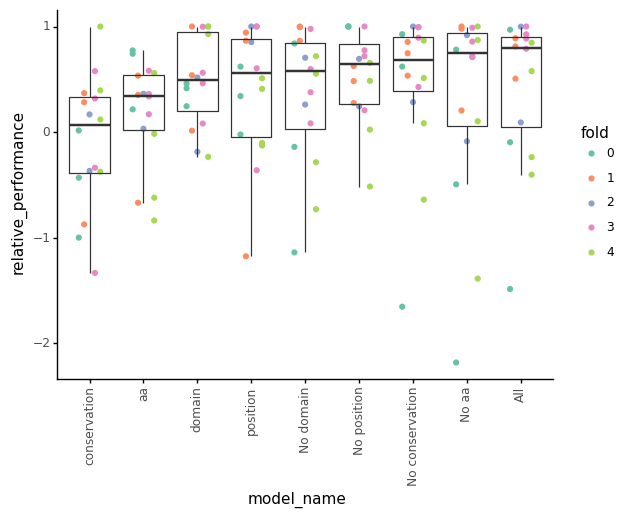

<ggplot: (8765888381715)>

In [32]:
plot_relative_performance(leave_one_predictive_performance)

feature_importance_df = (pd.concat(shap_importance_list, axis=1)
                         .reset_index()
                         .rename({'index': 'feature'}, axis=1)
                         .melt(id_vars='feature', var_name='fold', value_name='importance'))

avg_feature_importance = (feature_importance_df.groupby('feature')
                          .agg(avg_importance = ('importance', 'mean'),
                               std_importance = ('importance', 'std'))
                          .sort_values('avg_importance', ascending=False)
                          .reset_index())
avg_feature_importance['importance_high'] = avg_feature_importance['avg_importance'] + 2*avg_feature_importance['std_importance']
avg_feature_importance['importance_low'] = avg_feature_importance['avg_importance'] - 2*avg_feature_importance['std_importance']

top_n = 20
top_features = avg_feature_importance.head(top_n)
top_features['feature'] = pd.Categorical(top_features['feature'], categories=top_features['feature'])
(gg.ggplot(top_features) +
 gg.aes(x='feature', y='avg_importance',
        ymax='importance_high', ymin='importance_low') +
 gg.geom_col() +
 gg.geom_linerange() +
 gg.coord_flip())